# Bayesian Relationship between the EUROSTOXX50 and ECB interest rates

This isn't supposed to be a rigourous exercise, it is more meant as a way to dip my toes back into the Pandas waters.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
from pandas import Series, DataFrame
%matplotlib inline

First we'll define the start and end dates. The Euro Stoxx 50 started on 26/02/1998 so the start date will be set to then.

In [2]:
start = datetime.datetime(1998, 2, 26)
end = datetime.datetime(2020, 3, 1)

Now lets get the historical data for between these dates, and keep just the date and the close price (for simplicity):

In [3]:
df = web.DataReader('^STOXX50E', 'yahoo', start, end)
close = df[['Close']]
close.head()

,Close
Date,
1998-02-26,2875.610107
1998-02-27,2878.040039
1998-03-02,2929.020020
1998-03-03,2908.590088
1998-03-04,2878.590088


Next we need to get the historical interest rate changes from the ECB. To do this we'll get the table from the [ECB website](https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html).

In [4]:
tables = pd.read_html('https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html')
tables[0].head()

,Date,Deposit facility,Main refinancing operations,Marginal lending facility,Unnamed: 4_level_0,Unnamed: 5_level_0
,Unnamed: 0_level_1,Unnamed: 1_level_1,Fixed rate tenders Fixed rate,Variable rate tenders Minimum bid rate,Unnamed: 4_level_1,Unnamed: 5_level_1
,With effect from,Unnamed: 1_level_2,Unnamed: 2_level_2,Unnamed: 3_level_2,Unnamed: 4_level_2,Unnamed: 5_level_2
0,2019,18 Sep.,−0.50,0.00,-,0.25
1,2016,16 Mar.,−0.40,0.00,-,0.25
2,2015,9 Dec.,−0.30,0.05,-,0.30
3,2014,10 Sep.,−0.20,0.05,-,0.30
4,NaN,11 Jun.,−0.10,0.15,-,0.40


We get the right table with all the right data in, but the headings and data are messy. First the headings and columns need to be cleared up:

In [5]:
interest_rates = tables[0][['Date', 'Deposit facility', 'Marginal lending facility', 'Unnamed: 4_level_0']]
interest_rates.columns = ['Year','Month Day', 'Interest 1', 'Interest 2']
interest_rates.head()

,Year,Month Day,Interest 1,Interest 2
0,2019,18 Sep.,0.00,-
1,2016,16 Mar.,0.00,-
2,2015,9 Dec.,0.05,-
3,2014,10 Sep.,0.05,-
4,NaN,11 Jun.,0.15,-


I'm not sure why, but I was having issues using droplevel multiple times and recalculating the table so I reassigned the columns all in one operation. Now we need to clean up the data. Firstly the interest rate columns need to be merged, as well as useless rows removed.

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'
interest_rates['rate'] = interest_rates['Interest 1'] + interest_rates['Interest 2']
interest_rates = interest_rates.drop(columns=['Interest 1', 'Interest 2'])
interest_rates = interest_rates.drop([19, 20, 49])
interest_rates['rate'] = interest_rates['rate'].map(lambda x : float(str(x).strip('-')))
interest_rates.head()

,Year,Month Day,rate
0,2019,18 Sep.,0.00
1,2016,16 Mar.,0.00
2,2015,9 Dec.,0.05
3,2014,10 Sep.,0.05
4,NaN,11 Jun.,0.15


Now we need to sort out the date issues. This means we need to merge the date columns into one and then parse them.

In [7]:
interest_rates = interest_rates.fillna(method='ffill')
interest_rates['date'] = interest_rates['Year'] + ' ' + interest_rates['Month Day']
interest_rates['date'] = interest_rates['date'].map(
    lambda x: datetime.datetime.strptime(x.split('.')[0], '%Y %d %b')
)
interest_rates = interest_rates.drop(columns=['Year','Month Day'])
interest_rates = interest_rates.set_index('date')
interest_rates.head()

,rate
date,
2019-09-18,0.00
2016-03-16,0.00
2015-12-09,0.05
2014-09-10,0.05
2014-06-11,0.15


Since we're only taking MRO interest rates, we have duplicate  adjacent rows where another rate changed but the MRO rate stayed the same. In these cases we want to keep the last row, since the oldest change is where it actually changed.

In [8]:
a = interest_rates['rate']
interest_rates = a.loc[a.shift(-1) != a].to_frame()
interest_rates.head()

,rate
date,
2016-03-16,0.00
2014-09-10,0.05
2014-06-11,0.15
2013-11-13,0.25
2013-05-08,0.50


To calculate whether the EUROSTOXX50 index goes up or down depending on the interest rate change, we need to get the interest rate changes, not the interest rates themselves:

In [9]:
interest_rates['change'] = interest_rates.sort_index()['rate'].diff()
interest_rates.sort_index().head()

,rate,change
date,,
1999-01-01,3.00,NaN
1999-04-09,2.50,-0.50
1999-11-05,3.00,0.50
2000-02-04,3.25,0.25
2000-03-17,3.50,0.25


Let's see what the interest rates and the index look like on a simple line graph first:

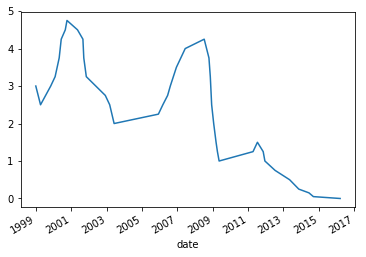

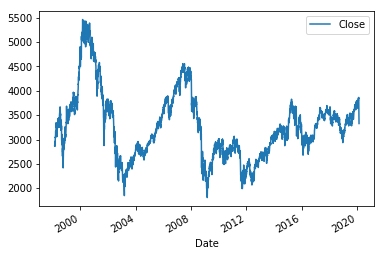

In [12]:
interest_rates['rate'].plot.line()
close.plot.line()

If we want to find the correlation between interest rate changes and stock market changes we need to get the stock market change values as well. We'll define the change as being the difference between the closing price the day before the interest rate changed and the closing price the day the interest rate changed. We just need these changes, not the changes for every day.